In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset = 'mrpc' # mrpc, manual
model_name = 't5-small' #t5-small, t5-base

folder_input_path = '/content/drive/My Drive/Colab Notebooks/8_Text_Paraphrasing/data/'
folder_pretrained_path = f'/content/drive/My Drive/Colab Notebooks/8_Text_Paraphrasing/pretrained/{dataset}-{model_name}-cc'
img_path = '/content/drive/My Drive/Colab Notebooks/8_Text_Paraphrasing/plots/'
csv_file_path = f'{dataset}-triplet-corpus-extended.csv'
folder_pretrained_path

'/content/drive/My Drive/Colab Notebooks/8_Text_Paraphrasing/pretrained/mrpc-t5-small-cc'

In [3]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import pandas as pd
from tqdm.auto import tqdm

from transformers import pipeline

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the dataset
df = pd.read_csv(folder_input_path + csv_file_path)
# Split the dataset into training and validation sets
df = df[['original', 'positive', 'negative',
               'positive_sentiment_label', 'positive_sentiment_score',
               'negative_sentiment_label', 'negative_sentiment_score',
               'positive_bert', 'negative_bert',
               'positive_cosine_similarity',
               'negative_cosine_similarity', 'split']]
df.shape

(1056, 12)

In [5]:
df.columns

Index(['original', 'positive', 'negative', 'positive_sentiment_label',
       'positive_sentiment_score', 'negative_sentiment_label',
       'negative_sentiment_score', 'positive_bert', 'negative_bert',
       'positive_cosine_similarity', 'negative_cosine_similarity', 'split'],
      dtype='object')

In [6]:
df['positive_sentiment_label'].value_counts()

POS    728
NEU    326
NEG      2
Name: positive_sentiment_label, dtype: int64

In [7]:
df['negative_sentiment_label'].value_counts()

NEG    867
NEU    184
POS      5
Name: negative_sentiment_label, dtype: int64

In [8]:
tokenizer = T5Tokenizer.from_pretrained(folder_pretrained_path)
model = T5ForConditionalGeneration.from_pretrained(folder_pretrained_path)
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

#Generate paraprases

In [9]:
model.eval()
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    input_text = f"paraphrase: [{row['positive_sentiment_label']}] {row['original']}"
    input_token = tokenizer.encode(input_text, return_tensors="pt").to(device)
    generated_ids = model.generate(input_token, max_length=50, num_beams=5, early_stopping=True)
    paraphrase = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    df.at[index, 'positive_paraphrase'] = paraphrase

  0%|          | 0/1056 [00:00<?, ?it/s]

In [10]:
model.eval()
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    input_text = f"paraphrase: [{row['negative_sentiment_label']}] {row['original']}"
    input_token = tokenizer.encode(input_text, return_tensors="pt").to(device)
    generated_ids = model.generate(input_token, max_length=50, num_beams=5, early_stopping=True)
    paraphrase = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    df.at[index, 'negative_paraphrase'] = paraphrase

  0%|          | 0/1056 [00:00<?, ?it/s]

#Extract paraphrases sentiment

In [11]:
tqdm.pandas()

# Load the sentiment analysis pipeline
model = pipeline('sentiment-analysis', model="finiteautomata/bertweet-base-sentiment-analysis")

# Function to get sentiment label and score
def get_sentiment(sentence):
    result = model(sentence)[0]
    return result['label'], result['score']

# Apply the function to each sentence column and create new columns for label and score
for column in ['positive_paraphrase', 'negative_paraphrase']:
    df[[column + '_sentiment_label', column + '_sentiment_score']] = df[column].progress_apply(
        lambda x: pd.Series(get_sentiment(x))
    )

df.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


  0%|          | 0/1056 [00:00<?, ?it/s]

  0%|          | 0/1056 [00:00<?, ?it/s]

,original,positive,negative,positive_sentiment_label,positive_sentiment_score,negative_sentiment_label,negative_sentiment_score,positive_bert,negative_bert,positive_cosine_similarity,negative_cosine_similarity,split,positive_paraphrase,negative_paraphrase,positive_paraphrase_sentiment_label,positive_paraphrase_sentiment_score,negative_paraphrase_sentiment_label,negative_paraphrase_sentiment_score
0,"But the new study , from the Women 's Health I...",The Women's Health Initiative's new study cont...,The discovery so alarmed researchers that they...,POS,0.912806,NEG,0.851633,0.631504,0.609009,0.658846,0.607798,train,The Women's Health Initiative's new study cont...,The discovery so alarmed researchers that they...,POS,0.912806,NEG,0.791803
1,"Voters in Cleveland Heights , Ohio , were aske...","Voters in Cleveland Heights , Ohio , approved ...",The vote in Cleveland Heights on domestic part...,POS,0.833843,NEU,0.672142,0.918156,0.608391,0.931605,0.678035,train,"Voters in Cleveland Heights, Ohio, approved a ...",The vote in Cleveland Heights on domestic part...,POS,0.805028,NEU,0.622748
2,The department 's position threatens to aliena...,The department's stance challenges to balance ...,The department 's stance disappointed some abo...,NEU,0.897464,NEG,0.823131,0.606762,0.879243,0.583568,0.859749,train,The department's stance disappointed some abor...,The department's stance disappointed some abor...,NEG,0.869722,NEG,0.869722
3,"Dr. Belding Scribner , inventor of a device th...",History will remember the University of Washin...,"Dr. Scribner's death marks a significant loss,...",POS,0.969818,NEG,0.969146,0.722581,0.584958,0.880067,0.745456,train,History will remember the University of Washin...,"Dr. Scribner's death marks a significant loss,...",POS,0.969923,NEG,0.969145
4,""" In 1980 , 6 % of children aged six to 18 wer...",The increase in childhood overweight rates sin...,"From 1976 to 1980 , it said , 6 percent of chi...",NEU,0.765868,NEG,0.566325,0.487997,0.807759,0.553025,0.933886,train,"From 1976 to 1980, it said, it would be the nu...","From 1976 to 1980, it said, it's pretty overwe...",NEU,0.836252,NEU,0.909217


# Visualize

In [31]:
split = 'train' # train, test

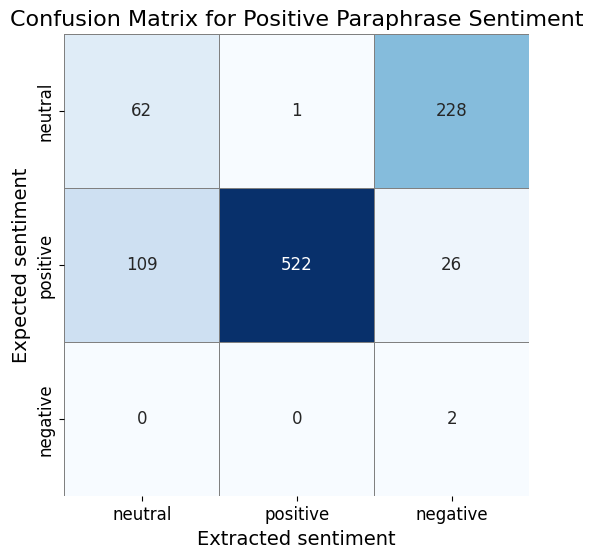

In [32]:
# Prepare the data
true_labels = df['positive_sentiment_label'][df['split'] == split]
predicted_labels = df['positive_paraphrase_sentiment_label'][df['split'] == split]

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=["NEU", "POS", "NEG"])

# Plot the confusion matrix
plt.figure(figsize=(6, 6))  # Larger figure size
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["neutral", "positive", "negative"], yticklabels=["neutral", "positive", "negative"], linewidths=0.5, linecolor='gray', cbar=False, annot_kws={"size": 12})
plt.title('Confusion Matrix for Positive Paraphrase Sentiment', fontsize=16)
plt.xlabel('Extracted sentiment', fontsize=14)
plt.ylabel('Expected sentiment', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig(img_path + f'{dataset}-confusion_matrix-positive-paraphrase-sentiment-{split}.png', dpi=300, bbox_inches='tight')
plt.show()

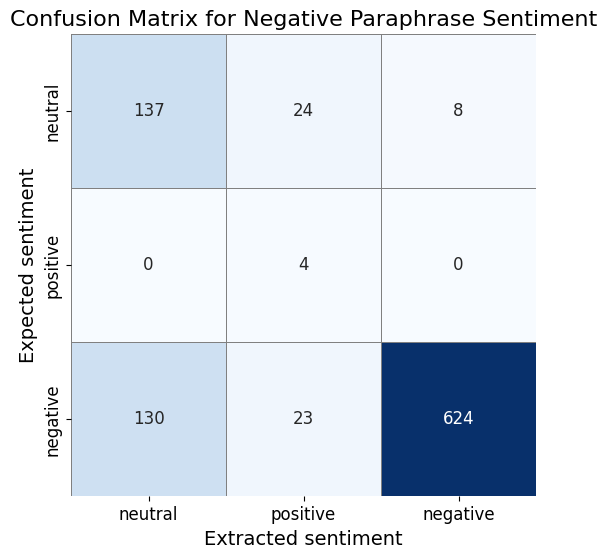

In [33]:
# Prepare the data
true_labels = df['negative_sentiment_label'][df['split'] == split]
predicted_labels = df['negative_paraphrase_sentiment_label'][df['split'] == split]

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=["NEU", "POS", "NEG"])

# Plot the confusion matrix
plt.figure(figsize=(6, 6))  # Larger figure size
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["neutral", "positive", "negative"], yticklabels=["neutral", "positive", "negative"], linewidths=0.5, linecolor='gray', cbar=False, annot_kws={"size": 12})
plt.title('Confusion Matrix for Negative Paraphrase Sentiment', fontsize=16)
plt.xlabel('Extracted sentiment', fontsize=14)
plt.ylabel('Expected sentiment', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig(img_path + f'{dataset}-confusion_matrix-negative-paraphrase-sentiment-{split}.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
!pip install -q bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.5 MB/s eta 0:00:00


In [18]:
!pip install -q sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 4.5 MB/s eta 0:00:00


In [27]:
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from bert_score import BERTScorer

scorer = BERTScorer(model_type='bert-base-uncased', device=None, lang='en')


def compute_bertscore(original, paraphrase):
    # Since BERTScore expects lists of sentences, wrap inputs in lists
    P, R, F1 = scorer.score([paraphrase], [original], verbose=False)

    # Return the F1 score
    return F1.item()

# Add new columns for scores of positive and negative paraphrases
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    # Assigning scores to the DataFrame
    df.at[index, 'positive_paraphrase_bert'] = compute_bertscore(row['positive'], row['positive_paraphrase'])
    df.at[index, 'negative_paraphrase_bert'] = compute_bertscore(row['negative'], row['negative_paraphrase'])

df.head()

  0%|          | 0/1056 [00:00<?, ?it/s]

,original,positive,negative,positive_sentiment_label,positive_sentiment_score,negative_sentiment_label,negative_sentiment_score,positive_bert,negative_bert,positive_cosine_similarity,...,positive_paraphrase,negative_paraphrase,positive_paraphrase_sentiment_label,positive_paraphrase_sentiment_score,negative_paraphrase_sentiment_label,negative_paraphrase_sentiment_score,positive_paraphrase_bert,negative_paraphrase_bert,positive_paraphrase_cosine_similarity,negative_paraphrase_cosine_similarity
0,"But the new study , from the Women 's Health I...",The Women's Health Initiative's new study cont...,The discovery so alarmed researchers that they...,POS,0.912806,NEG,0.851633,0.631504,0.609009,0.658846,...,The Women's Health Initiative's new study cont...,The discovery so alarmed researchers that they...,POS,0.912806,NEG,0.791803,1.000000,1.000000,1.000000,1.000000
1,"Voters in Cleveland Heights , Ohio , were aske...","Voters in Cleveland Heights , Ohio , approved ...",The vote in Cleveland Heights on domestic part...,POS,0.833843,NEU,0.672142,0.918156,0.608391,0.931605,...,"Voters in Cleveland Heights, Ohio, approved a ...",The vote in Cleveland Heights on domestic part...,POS,0.805028,NEU,0.622748,0.979527,0.973213,0.999291,0.993762
2,The department 's position threatens to aliena...,The department's stance challenges to balance ...,The department 's stance disappointed some abo...,NEU,0.897464,NEG,0.823131,0.606762,0.879243,0.583568,...,The department's stance disappointed some abor...,The department's stance disappointed some abor...,NEG,0.869722,NEG,0.869722,0.588820,1.000000,0.600273,1.000000
3,"Dr. Belding Scribner , inventor of a device th...",History will remember the University of Washin...,"Dr. Scribner's death marks a significant loss,...",POS,0.969818,NEG,0.969146,0.722581,0.584958,0.880067,...,History will remember the University of Washin...,"Dr. Scribner's death marks a significant loss,...",POS,0.969923,NEG,0.969145,0.913877,1.000000,0.951146,1.000000
4,""" In 1980 , 6 % of children aged six to 18 wer...",The increase in childhood overweight rates sin...,"From 1976 to 1980 , it said , 6 percent of chi...",NEU,0.765868,NEG,0.566325,0.487997,0.807759,0.553025,...,"From 1976 to 1980, it said, it would be the nu...","From 1976 to 1980, it said, it's pretty overwe...",NEU,0.836252,NEU,0.909217,0.482346,0.650966,0.580161,0.511279


In [20]:
from sentence_transformers import SentenceTransformer, util

# Load the model
model = SentenceTransformer('all-mpnet-base-v2')

def compute_cosine_similarity(original, paraphrase, threshold=0.75):
    # Compute embeddings
    embeddings_original = model.encode(original, convert_to_tensor=True)
    embeddings_paraphrase = model.encode(paraphrase, convert_to_tensor=True)

    # Compute cosine similarity
    cosine_scores = util.pytorch_cos_sim(embeddings_original, embeddings_paraphrase)

    return cosine_scores.item() # >= threshold

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    df.at[index, 'positive_paraphrase_cosine_similarity'] = compute_cosine_similarity(row['positive'], row['positive_paraphrase'])
    df.at[index, 'negative_paraphrase_cosine_similarity'] = compute_cosine_similarity(row['negative'], row['negative_paraphrase'])

df.head()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  0%|          | 0/1056 [00:00<?, ?it/s]

,original,positive,negative,positive_sentiment_label,positive_sentiment_score,negative_sentiment_label,negative_sentiment_score,positive_bert,negative_bert,positive_cosine_similarity,...,positive_paraphrase,negative_paraphrase,positive_paraphrase_sentiment_label,positive_paraphrase_sentiment_score,negative_paraphrase_sentiment_label,negative_paraphrase_sentiment_score,positive_paraphrase_bert,negative_paraphrase_bert,positive_paraphrase_cosine_similarity,negative_paraphrase_cosine_similarity
0,"But the new study , from the Women 's Health I...",The Women's Health Initiative's new study cont...,The discovery so alarmed researchers that they...,POS,0.912806,NEG,0.851633,0.631504,0.609009,0.658846,...,The Women's Health Initiative's new study cont...,The discovery so alarmed researchers that they...,POS,0.912806,NEG,0.791803,1.000000,1.000000,1.000000,1.000000
1,"Voters in Cleveland Heights , Ohio , were aske...","Voters in Cleveland Heights , Ohio , approved ...",The vote in Cleveland Heights on domestic part...,POS,0.833843,NEU,0.672142,0.918156,0.608391,0.931605,...,"Voters in Cleveland Heights, Ohio, approved a ...",The vote in Cleveland Heights on domestic part...,POS,0.805028,NEU,0.622748,0.979527,0.973213,0.999291,0.993762
2,The department 's position threatens to aliena...,The department's stance challenges to balance ...,The department 's stance disappointed some abo...,NEU,0.897464,NEG,0.823131,0.606762,0.879243,0.583568,...,The department's stance disappointed some abor...,The department's stance disappointed some abor...,NEG,0.869722,NEG,0.869722,0.588820,1.000000,0.600273,1.000000
3,"Dr. Belding Scribner , inventor of a device th...",History will remember the University of Washin...,"Dr. Scribner's death marks a significant loss,...",POS,0.969818,NEG,0.969146,0.722581,0.584958,0.880067,...,History will remember the University of Washin...,"Dr. Scribner's death marks a significant loss,...",POS,0.969923,NEG,0.969145,0.913877,1.000000,0.951146,1.000000
4,""" In 1980 , 6 % of children aged six to 18 wer...",The increase in childhood overweight rates sin...,"From 1976 to 1980 , it said , 6 percent of chi...",NEU,0.765868,NEG,0.566325,0.487997,0.807759,0.553025,...,"From 1976 to 1980, it said, it would be the nu...","From 1976 to 1980, it said, it's pretty overwe...",NEU,0.836252,NEU,0.909217,0.482346,0.650966,0.580161,0.511279


In [28]:
positive_column_labels = {
    'positive_paraphrase_bert': 'BERT Score',
    'positive_paraphrase_cosine_similarity': 'Cosine Similarity'
}

negative_column_labels = {k.replace('positive', 'negative'): v for k, v in positive_column_labels.items()}

# Select the data for positive and negative measures
positive_data = df[positive_column_labels.keys()][df['split'] == split]
negative_data = df[negative_column_labels.keys()][df['split'] == split]

# Define an expanded color palette suitable for color-blind readers
color_palette = [
    '#17becf',  # Cyan
    '#b2df8a',  # Light Green
]

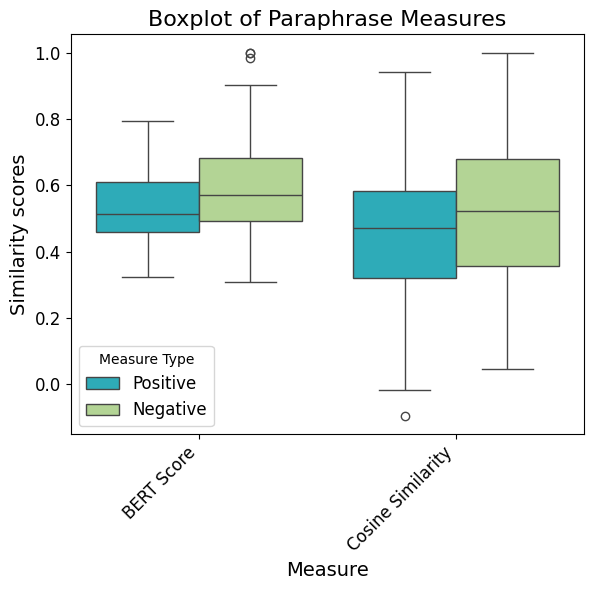

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it's already been filtered to include only 'test' split data as shown above.

# Combine positive and negative data
positive_data['Measure Type'] = 'Positive'
negative_data['Measure Type'] = 'Negative'
combined_data = pd.concat([positive_data.rename(columns=positive_column_labels), negative_data.rename(columns=negative_column_labels)])

# Melt the combined DataFrame
melted_data = pd.melt(combined_data, id_vars=['Measure Type'], var_name='Measure', value_name='Similarity Score')

# Plot
plt.figure(figsize=(6, 6))
sns.boxplot(x='Measure', y='Similarity Score', hue='Measure Type', data=melted_data, palette=color_palette)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.title('Boxplot of Paraphrase Measures', fontsize=16)
plt.ylabel('Similarity scores', fontsize=14)
plt.xlabel('Measure', fontsize=14)
plt.legend(title='Measure Type', fontsize=12)
plt.tight_layout()
plt.yticks(fontsize=12)

plt.savefig(img_path + f'{dataset}-boxplot-paraphrase-similarity-{split}.png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics_columns = ['Accuracy', 'Precision POS', 'Precision NEG', 'Precision NEU', 'Recall POS', 'Recall NEG', 'Recall NEU', 'F1 POS', 'F1 NEG', 'F1 NEU', 'BERT Score Mean', 'Cosine Similarity Mean']
results = {metric: [] for metric in metrics_columns}

for sentiment in ['positive', 'negative']:
    true_labels = df[sentiment + '_sentiment_label'][df['split'] == split]
    predicted_labels = df[sentiment + '_paraphrase_sentiment_label'][df['split'] == split]

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average=None, labels=['POS', 'NEG', 'NEU'], zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average=None, labels=['POS', 'NEG', 'NEU'], zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average=None, labels=['POS', 'NEG', 'NEU'], zero_division=0)
    bert_score_mean = np.mean(df[sentiment + '_paraphrase_bert'][df['split'] == split])
    cos_sim_mean = np.mean(df[sentiment + '_paraphrase_cosine_similarity'][df['split'] == split])

    # Update the results dictionary with each metric
    results['Accuracy'].append(accuracy)
    results['Precision POS'].append(precision[0])
    results['Precision NEG'].append(precision[1])
    results['Precision NEU'].append(precision[2])
    results['Recall POS'].append(recall[0])
    results['Recall NEG'].append(recall[1])
    results['Recall NEU'].append(recall[2])
    results['F1 POS'].append(f1[0])
    results['F1 NEG'].append(f1[1])
    results['F1 NEU'].append(f1[2])
    results['BERT Score Mean'].append(bert_score_mean)
    results['Cosine Similarity Mean'].append(cos_sim_mean)

# Convert results to a DataFrame with 'positive' and 'negative' as columns
df_results = pd.DataFrame(results, index=['Positive', 'Negative']).T
df_results.to_latex()


<ipython-input-35-f00ba1781abe>:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_results.to_latex()


'\\begin{tabular}{lrr}\n\\toprule\n{} &  Positive &  Negative \\\\\n\\midrule\nAccuracy               &  0.616842 &  0.805263 \\\\\nPrecision POS          &  0.998088 &  0.078431 \\\\\nPrecision NEG          &  0.007812 &  0.987342 \\\\\nPrecision NEU          &  0.362573 &  0.513109 \\\\\nRecall POS             &  0.794521 &  1.000000 \\\\\nRecall NEG             &  1.000000 &  0.803089 \\\\\nRecall NEU             &  0.213058 &  0.810651 \\\\\nF1 POS                 &  0.884746 &  0.145455 \\\\\nF1 NEG                 &  0.015504 &  0.885735 \\\\\nF1 NEU                 &  0.268398 &  0.628440 \\\\\nBERT Score Mean        &  0.807414 &  0.925052 \\\\\nCosine Similarity Mean &  0.805878 &  0.924662 \\\\\n\\bottomrule\n\\end{tabular}\n'